In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Eeltöötlus

In [ ]:
#Andmed on pärit https://andmeladu.elering.ee/consumer/home (2011-2021)
url = 'http://lennuki.myqnapcloud.com:8080/share.cgi?ssid=02mwhAw&fid=02mwhAw&filename=el.xlsx&openfolder=forcedownload&ep='

data_df = pd.read_excel(url,  header=1)
data_df = data_df.iloc[12456:82584] #from 2013 we have hourly data, drop rows before that. Drop values of year 2021
data_df.drop(data_df.columns[[2,3]],axis=1,inplace=True) #drop cols where there is no needed information
data_df.reset_index(inplace=True, drop=True)

In [ ]:
date_info_df = data_df["Tund"].str.split(" ", expand = True)
data_df['Date']= date_info_df[0] 
data_df['Hour']= date_info_df[2] 
data_df['Weekday']= date_info_df[1]

#Merge columns to convert it to datetime
data_df["Datetime"] = data_df['Date'] + ' ' + data_df['Hour']
data_df.drop(data_df.columns[[0,3]],axis=1,inplace=True)

#covert to datetime
data_df['Datetime']=pd.to_datetime(data_df['Datetime'], format='%d.%m.%Y %H:%M')
data_df['Date']=pd.to_datetime(data_df['Date'], format='%d.%m.%Y')
data_df['Date']=data_df['Date'].dt.strftime('%Y-%m-%d')
#Convert hour to numeric
data_df['Hour'] = data_df['Datetime'].dt.strftime('%H')
data_df['Hour'] = pd.to_numeric(data_df['Hour'])

#Add weekend information
holidays = ['01-01', '02-24', '05-01', '06-23', '06-24', '08-20', '12-24', '12-25', '12-26']

#suur reede, ülestõusmispüha 1 püha, nelipüha
moving_holidays = ['2013-03-29','2014-04-18','2015-04-03','2016-03-25','2017-04-14','2018-03-30','2019-04-19','2020-04-10',
                   '2013-03-31','2014-04-20','2015-04-05','2016-03-27', '2017-04-16','2018-04-01','2019-04-21','2020-04-12',
                   '2013-05-19','2014-06-08','2015-05-24','2016-05-15', '2017-06-04', '2018-05-20','2019-06-09', '2020-05-31']


weekend_conditions = [(data_df['Weekday'] == 'L'), (data_df['Weekday'] == 'P'), (data_df['Datetime'].dt.strftime('%m-%d').isin(holidays)),
                                                                                 (data_df['Datetime'].dt.strftime('%Y-%m-%d').isin(moving_holidays))] #L is Saturday and P is Sunday
weekend_values = [1, 1, 1, 1]

data_df['Weekend'] = np.select(weekend_conditions, weekend_values, default = 0)

#Add season(winter, spring, summer, autumn) information based on month
data_df['Month'] = data_df['Datetime'].dt.strftime('%m')
data_df['Month'] = pd.to_numeric(data_df['Month'])
season_conditions = [(data_df['Month'] <= 3), 
                    (data_df['Month'] >= 4)  & (data_df['Month'] <= 6),
                    (data_df['Month'] >= 7)  & (data_df['Month'] <= 9),
                    (data_df['Month'] >= 10)  & (data_df['Month'] <= 12)]
season_values = [ 'Winter', 'Spring', 'Summer', 'Autumn']
data_df['Season'] = np.select(season_conditions, season_values)
#data_df=data_df.drop(['Month'], axis=1)

data_df['Year'] = data_df['Datetime'].dt.strftime('%Y')

data_df['Datetime2'] = data_df['Datetime']

# Set date column as index 
index_data = data_df.set_index('Datetime')
index_data['Day_of_year'] = index_data.index.dayofyear
index_data['Week_nr'] = index_data.index.week

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


# Visualiseerimine

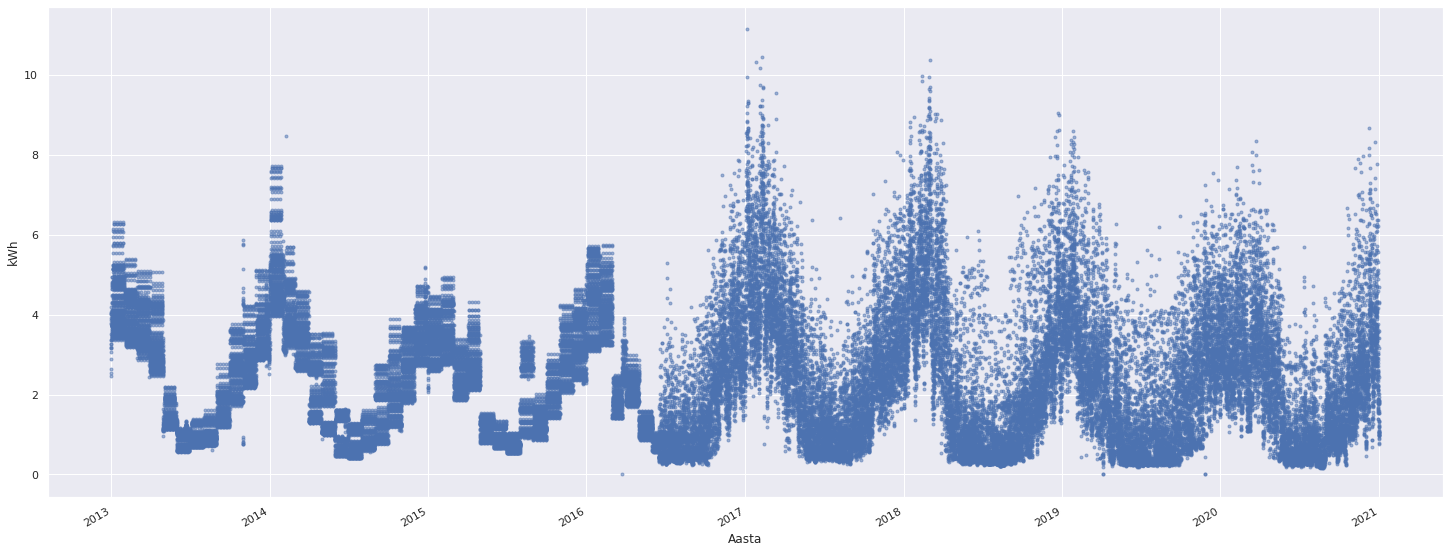

In [ ]:
sns.set(rc={'figure.figsize':(11, 4)})
axes = index_data['Tarbimine'].plot(marker='.', alpha=0.5, linestyle='None', figsize=(25, 10), subplots=True)
for ax in axes:
    ax.set_ylabel('kWh')
    ax.set_xlabel('Aasta')

In [ ]:
#Use data from 2017
index_data = index_data.loc['20170101':] 

In [ ]:
index_data.describe()

Tarbimine          Hour  ...   Day_of_year       Week_nr
count  35064.000000  35064.000000  ...  35064.000000  35064.000000
mean       2.413937     11.500000  ...    183.149612     26.593486
std        1.736307      6.922285  ...    105.442595     15.061648
min        0.000000      0.000000  ...      1.000000      1.000000
25%        0.931000      5.750000  ...     92.000000     14.000000
50%        2.116000     11.500000  ...    183.000000     27.000000
75%        3.494000     17.250000  ...    274.000000     40.000000
max       11.135000     23.000000  ...    366.000000     53.000000

[8 rows x 6 columns]

## Erindite tuvastamine
Otsustasin, et erindeid ei ole ja lihtsalt 0 väärtused on elektrikatkestused. Need asendand kõrvalolevate väärtustega

In [ ]:
index_data[index_data['Tarbimine'] == 0]

Tarbimine        Date  ... Day_of_year  Week_nr
Datetime                                    ...                     
2019-04-05 10:00:00        0.0  2019-04-05  ...          95       14
2019-04-05 11:00:00        0.0  2019-04-05  ...          95       14
2019-11-26 10:00:00        0.0  2019-11-26  ...         330       48
2019-11-26 11:00:00        0.0  2019-11-26  ...         330       48

[4 rows x 11 columns]

In [ ]:
index_data.at['2019-04-05 10:00:00', 'Tarbimine'] = index_data.loc['2019-04-05 09:00:00']['Tarbimine']
index_data.at['2019-04-05 11:00:00', 'Tarbimine'] = index_data.loc['2019-04-05 09:00:00']['Tarbimine']
index_data.at['2019-11-26 10:00:00', 'Tarbimine'] = index_data.loc['2019-11-26 09:00:00']['Tarbimine']
index_data.at['2019-11-26 11:00:00', 'Tarbimine'] = index_data.loc['2019-11-26 09:00:00']['Tarbimine']

## Kirjeldav statistika

## Histogrammid

(0.0, 9.0)

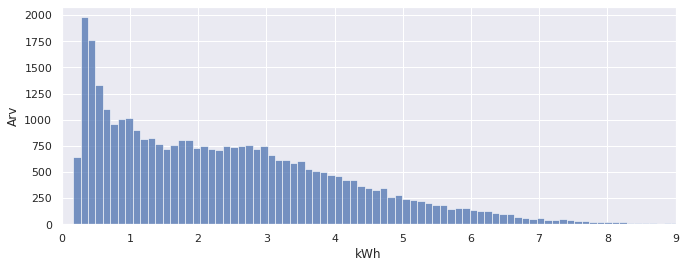

In [ ]:
ax = sns.histplot(data=index_data, x="Tarbimine", bins =100)
ax.set_xlabel("kWh")
ax.set_ylabel("Arv")
ax.set_xlim(0, 9)

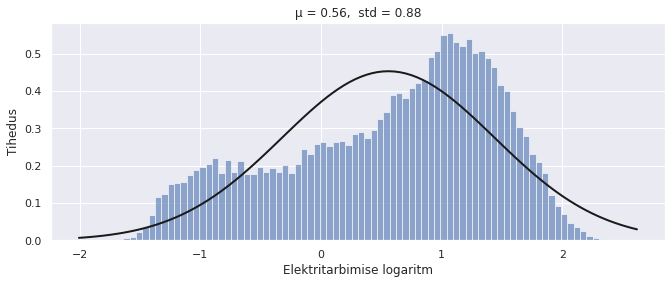

In [ ]:
from scipy.stats import norm
data_log = np.log(index_data['Tarbimine'])
mu, std = norm.fit(data_log)

plt.hist(data_log, bins=80, density=True, alpha=0.6)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "µ = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Elektritarbimise logaritm')
plt.ylabel('Tihedus')

plt.show()


In [ ]:
grouped_hour = index_data.groupby('Hour')['Tarbimine'].mean()
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
grouped_season = index_data.groupby('Season')['Tarbimine'].mean().reindex(seasons)
grouped_weekend = index_data.groupby('Weekend')['Tarbimine'].mean()
weekdays = ['E', 'T', 'K', 'N', 'R', 'L', 'P']
grouped_weekday = index_data.groupby('Weekday')['Tarbimine'].mean().reindex(weekdays)



data_2020 = index_data.loc['20200101':]
grouped_weekday_2020 = data_2020.groupby('Weekday')['Tarbimine'].mean().reindex(weekdays)

data_2017_2019 = index_data.loc[:'20191231']
grouped_weekday_2017_2019  = data_2017_2019.groupby('Weekday')['Tarbimine'].mean().reindex(weekdays)

### Erinevate aastate tarbimine

Text(0, 0.5, 'Aasta kogutarbimine kWh')

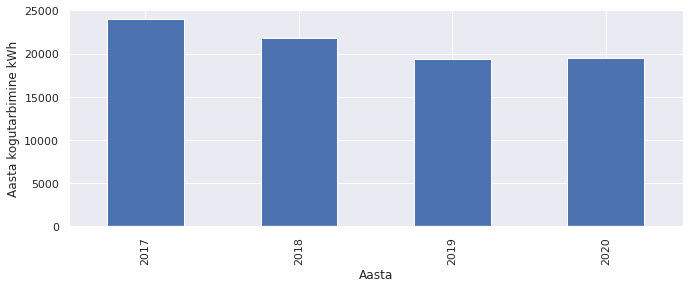

In [ ]:
grouped_year = index_data.groupby('Year')['Tarbimine'].sum()
ax = grouped_year.plot.bar()
ax.set_xlabel("Aasta")
ax.set_ylabel("Aasta kogutarbimine kWh")

### Tarbimine hooja põhiselt

([<matplotlib.axis.XTick at 0x7fe707557550>,
 [Text(0, 0, 'Talv'),
  Text(0, 0, 'Kevad'),
  Text(0, 0, 'Suvi'),
  Text(0, 0, 'Sügis')])

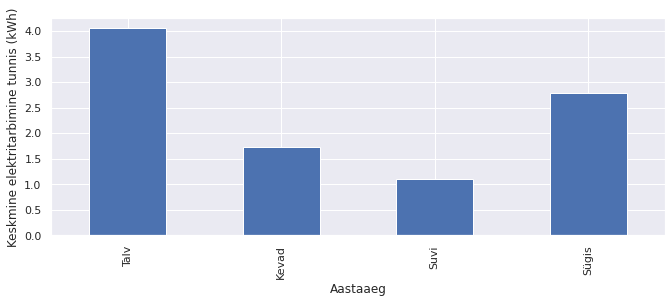

In [ ]:
#Average electicity hourly consuption by seasons
grouped_season.plot.bar()
plt.xlabel('Aastaaeg')
plt.ylabel('Keskmine elektritarbimine tunnis (kWh)')
plt.xticks([0,1,2,3], ['Talv', 'Kevad', 'Suvi', 'Sügis'])

Text(0, 0.5, 'Elektritarbimine tunnis (kWh)')

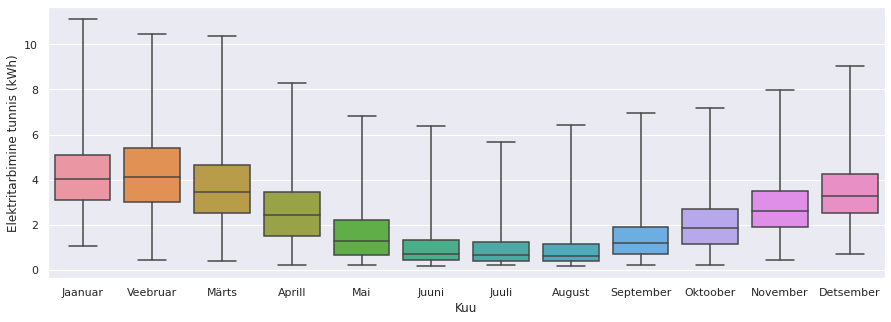

In [ ]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(15, 5))
sns.boxplot(x="Month", y="Tarbimine", data=index_data, ax=ax, whis = 10) # ,  showfliers = False
ax.set_xticklabels(['Jaanuar', 'Veebruar', 'Märts', 'Aprill','Mai', 'Juuni', 'Juuli', 'August', 'September', 'Oktoober', 'November', 'Detsember'])
ax.set_xlabel('Kuu')
ax.set_ylabel('Elektritarbimine tunnis (kWh)')

### Tarbimine nädalavahetus (sh pühad) vs argipäev

In [ ]:
#Average electicity hourly consuption by weekday (0) and weekend
grouped_weekend.plot.bar()
plt.xlabel('')
plt.ylabel('Keskmine elektritarbimine tunnis (kWh)')
plt.xticks([0,1], ['Argipäev', 'Nädalavahetus'], rotation = 0 )


([<matplotlib.axis.XTick at 0x7fe708654390>,
 [Text(0, 0, 'Argipäev'), Text(0, 0, 'Nädalavahetus')])

Text(0, 0.5, 'Keskmine elektritarbimine tunnis (kWh)')

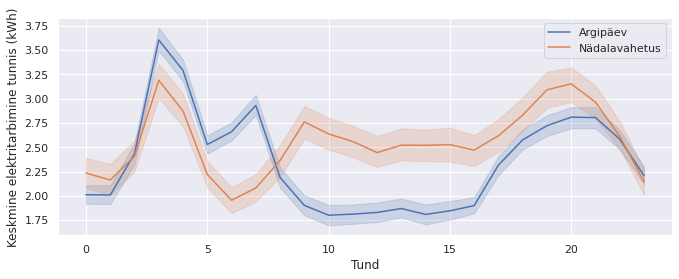

In [ ]:
fig,ax= plt.subplots()
plot_graph = sns.lineplot(data=index_data, x='Hour', y='Tarbimine', hue='Weekend', ax=ax);
plot_graph.legend(title=False, labels=['Argipäev', 'Nädalavahetus'])
ax.set_xlabel("Tund")
ax.set_ylabel('Keskmine elektritarbimine tunnis (kWh)')

### Tarbimine nädalapäeva lõikes

In [ ]:
grouped_weekday.plot(marker='o', linestyle='-')
plt.xlabel('')
plt.ylabel('Keskmine elektritarbimine tunnis (kWh)')
plt.xticks([0,1, 2, 3, 4, 5, 6, 7], ['Esmaspäev', 'Teisipäev', 'Kolmapäev', 'Neljapäev', 'Reede', 'Laupäev', 'Pühapäev'], rotation = 0 )

([<matplotlib.axis.XTick at 0x7fe708885d10>,
 [Text(0, 0, 'Esmaspäev'),
  Text(0, 0, 'Teisipäev'),
  Text(0, 0, 'Kolmapäev'),
  Text(0, 0, 'Neljapäev'),
  Text(0, 0, 'Reede'),
  Text(0, 0, 'Laupäev'),
  Text(0, 0, 'Pühapäev')])

([<matplotlib.axis.XTick at 0x7fe708885a50>,
 [Text(0, 0, 'Esmaspäev'),
  Text(0, 0, 'Teisipäev'),
  Text(0, 0, 'Kolmapäev'),
  Text(0, 0, 'Neljapäev'),
  Text(0, 0, 'Reede'),
  Text(0, 0, 'Laupäev'),
  Text(0, 0, 'Pühapäev')])

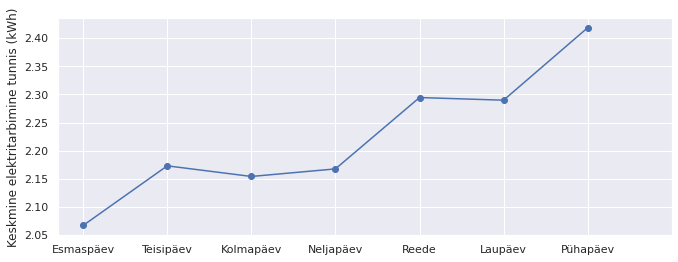

In [ ]:
grouped_weekday_2020.plot(marker='o', linestyle='-')
plt.xlabel('')
plt.ylabel('Keskmine elektritarbimine tunnis (kWh)')
plt.xticks([0,1, 2, 3, 4, 5, 6, 7], ['Esmaspäev', 'Teisipäev', 'Kolmapäev', 'Neljapäev', 'Reede', 'Laupäev', 'Pühapäev'], rotation = 0 )

([<matplotlib.axis.XTick at 0x7fe707213690>,
 [Text(0, 0, 'Esmaspäev'),
  Text(0, 0, 'Teisipäev'),
  Text(0, 0, 'Kolmapäev'),
  Text(0, 0, 'Neljapäev'),
  Text(0, 0, 'Reede'),
  Text(0, 0, 'Laupäev'),
  Text(0, 0, 'Pühapäev')])

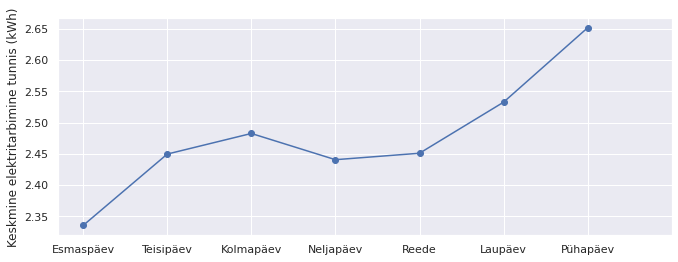

In [ ]:
grouped_weekday_2017_2019.plot(marker='o', linestyle='-')
plt.xlabel('')
plt.ylabel('Keskmine elektritarbimine tunnis (kWh)')
plt.xticks([0,1, 2, 3, 4, 5, 6, 7], ['Esmaspäev', 'Teisipäev', 'Kolmapäev', 'Neljapäev', 'Reede', 'Laupäev', 'Pühapäev'], rotation = 0 )

### Tunnipõhine tarbimine


Text(0, 0.5, 'Keskmine elektritarbimine tunnis (kWh)')

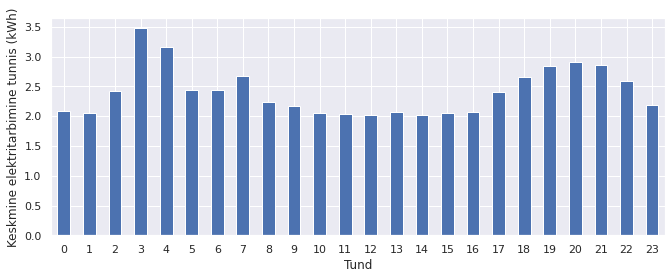

In [ ]:
#Average electicity hourly consuption
grouped_hour.plot.bar()
plt.xlabel('Tund')
plt.xticks(rotation = 0 )
plt.ylabel('Keskmine elektritarbimine tunnis (kWh)')

Text(0, 0.5, 'Keskmine elektritarbimine tunnis (kWh)')

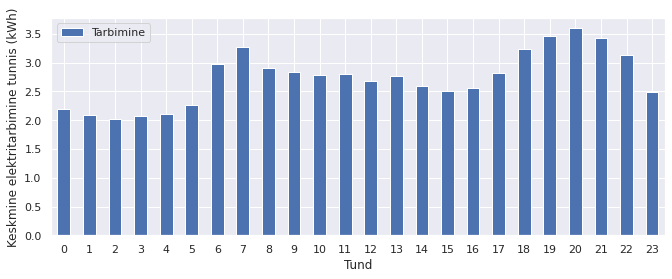

In [ ]:
grouped_hour_2017 = index_data.loc['20170101':'20171231'].groupby('Hour').agg({'Tarbimine':'mean'})
grouped_hour_2017.plot.bar()
plt.xlabel('Tund')
plt.xticks(rotation = 0 )
plt.ylabel('Keskmine elektritarbimine tunnis (kWh)')

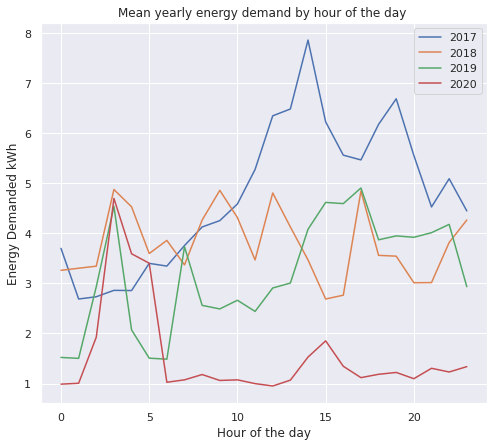

In [ ]:
group_hours = index_data['Tarbimine'].groupby(pd.Grouper(freq='D', how='mean'))

fig, axs = plt.subplots(1,1, figsize=(8,7))

year_demands = pd.DataFrame()
    
for name, group in group_hours:
    year_demands[name.year] = pd.Series(group.values)
    
year_demands.plot(ax=axs)
axs.set_xlabel('Hour of the day')
axs.set_ylabel('Energy Demanded kWh')
axs.set_title('Mean yearly energy demand by hour of the day ');

(0.0, 27.0)

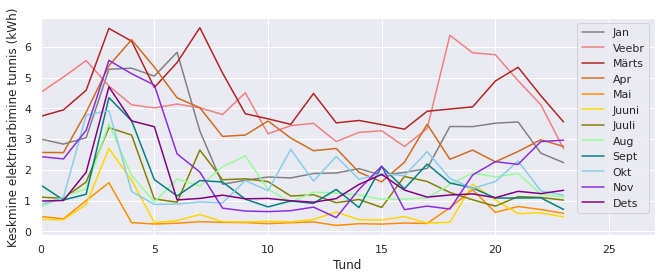

In [ ]:
group_hours = index_data['Tarbimine'].groupby(pd.Grouper(freq='D', how='mean'))

fig, axs = plt.subplots()

df = pd.DataFrame()
    
months = ['Jan', 'Veebr', 'Märts', 'Apr', 'Mai', 'Juuni', 'Juuli', 'Aug', 'Sept', 'Okt', 'Nov', 'Dets']    

for name, group in group_hours:
    df[name.month] = pd.Series(group.values)

    
colors = ['gray', 'lightcoral', 'firebrick', 'chocolate', 'darkorange', 'gold', 'olive', 'palegreen', 'teal', 'skyblue', 'blueviolet', 'purple']
df.columns = months
df.plot(ax=axs, color=colors)
axs.set_xlabel('Tund')
axs.set_ylabel('Keskmine elektritarbimine tunnis (kWh)')
plt.legend(loc='upper right')
axs.set_xlim(0,27)

## Päevane tarbimine vs nädala keskmine tarbimine

In [ ]:
consumption_daily= index_data[['Tarbimine']].resample('D').sum()
consumption_weekly_mean= consumption_daily[['Tarbimine']].resample('W').mean()

In [ ]:
# 7-day rolling mean
rolling_mean_7d = consumption_daily[['Tarbimine']].rolling(7, center=True).mean()

# 365-day rolling mean
rolling_mean_365d = consumption_daily[['Tarbimine']].rolling(window=365, center=True, min_periods=360).mean()

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(consumption_daily, marker='.', linestyle='-', linewidth=3, label='Päevane kogutarbimine')
ax.plot(consumption_weekly_mean, marker='o', markersize=5, linewidth=1.5, linestyle='-', label='Nädala keskmine tarbimine')

ax.set_ylabel('kWh')
ax.legend();

## Autokorrelatsioon

In [ ]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
autocorr = acf(index_data['Tarbimine'], nlags=96)
plot_pacf(index_data['Tarbimine'].tolist(), lags=96, ax=ax); 
ax.set_xlabel('n tundi tagasi')
ax.set_ylabel('Korrelatsioonikordaja')
ax.set_title('')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '')

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
autocorr = acf(consumption_daily['Tarbimine'], nlags=60)
plot_pacf(consumption_daily['Tarbimine'].tolist(), lags=30, ax=ax); 
ax.set_xlabel('n päeva tagasi')
ax.set_ylabel('Korrelatsioonikordaja')
ax.set_title('')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '')

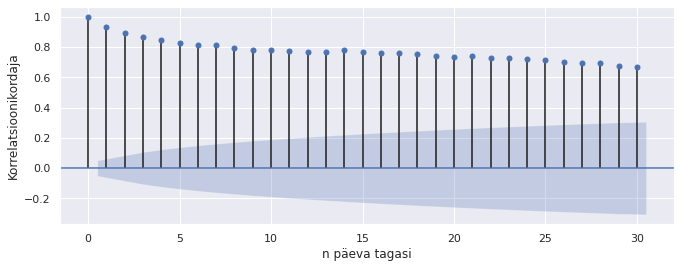

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
autocorr = acf(consumption_daily['Tarbimine'], nlags=60)
plot_acf(consumption_daily['Tarbimine'].tolist(), lags=30, ax=ax); 
ax.set_xlabel('n päeva tagasi')
ax.set_ylabel('Korrelatsioonikordaja')
ax.set_title('')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '')

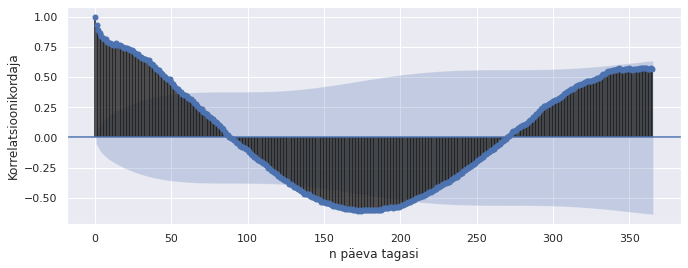

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
autocorr = acf(consumption_daily['Tarbimine'], nlags=365)
plot_acf(consumption_daily['Tarbimine'].tolist(), lags=365, ax=ax); 
ax.set_xlabel('n päeva tagasi')
ax.set_ylabel('Korrelatsioonikordaja')
ax.set_title('')

## Igaaastane tarbimine


In [ ]:
yearly_data_pivot = pd.pivot_table(index_data, index =['Day_of_year'], columns=['Year'], values=['Tarbimine'])

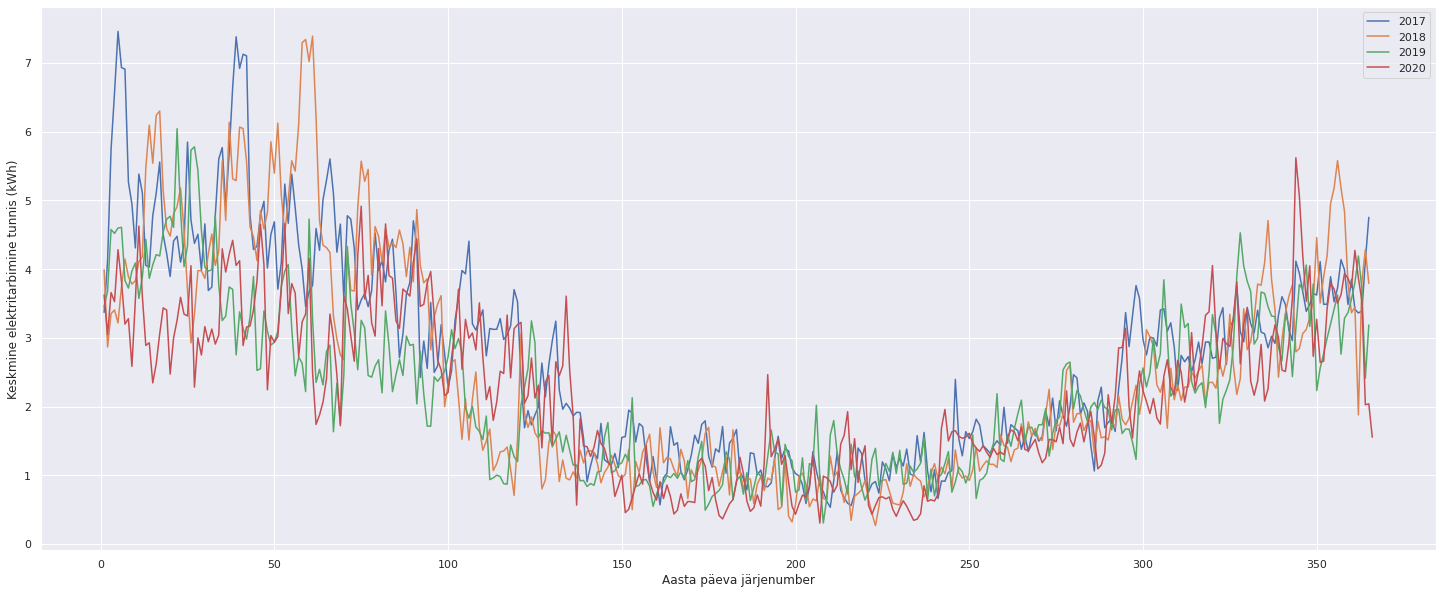

In [ ]:
#Average hourly consuption by day of year
yearly_data_pivot.plot(figsize=(25,10))
plt.ylabel('Keskmine elektritarbimine tunnis (kWh)')
plt.xlabel('Aasta päeva järjenumber')
plt.legend(['2017', '2018', '2019', '2020'])

In [ ]:
weekly_data_pivot = pd.pivot_table(index_data, index =['Week_nr'], columns=['Year'], values=['Tarbimine'])

In [ ]:
#Average hourly consuption by week number
weekly_data_pivot.plot(figsize=(20,10))

# Päevavalguse pikkus

https://colab.research.google.com/drive/1_c185jccuGeQ_hOukCt3qkL2tKQF5mF3?usp=sharing

In [ ]:
daylight_url = 'http://lennuki.myqnapcloud.com:8080/share.cgi?ssid=0j0PWw1&fid=0j0PWw1&filename=day_length.csv&openfolder=forcedownload&ep='
daylight_df = pd.read_csv(daylight_url)

In [ ]:
#Calculate consumption sum
yearly_data_by_day_sum = index_data.groupby("Date")['Tarbimine'].sum().reset_index(name ='consumption_sum')

#Add dailight information
yearly_data_by_day_sum_df = pd.merge(yearly_data_by_day_sum, daylight_df, on='Date')

Text(0.5, 0, 'Päevavalguse pikkus minutites')

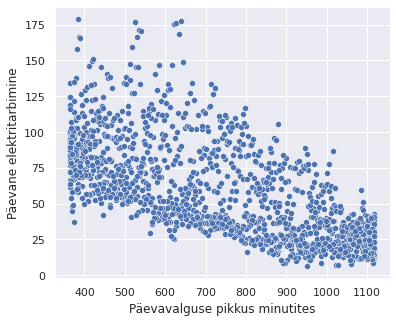

In [ ]:
#Relationship between consumption and day length
sns.set(rc={'figure.figsize':(6, 5)})
ax = sns.scatterplot(data =yearly_data_by_day_sum_df, y='consumption_sum', x='day_length')
ax.set_ylabel("Päevane elektritarbimine")
ax.set_xlabel("Päevavalguse pikkus minutites")

In [ ]:
yearly_data_by_day_sum_df['consumption_sum'] = np.log(yearly_data_by_day_sum_df['consumption_sum'])
#Relationship between consumption and day length
ax = sns.scatterplot(data =yearly_data_by_day_sum_df, y='consumption_sum', x='day_length')
ax.set_ylabel("Päevane elektritarbimine logaritmilisel skaalal")
ax.set_xlabel("Päevavalguse pikkus minutites")

Text(0.5, 0, 'Päevavalguse pikkus minutites')

In [ ]:
yearly_data_by_day_sum_df.drop(['Date'], axis=1, inplace=True)


In [ ]:
yearly_data_by_day_sum_df.corr(method='pearson')

consumption_sum  day_length
consumption_sum         1.000000   -0.739737
day_length             -0.739737    1.000000

In [ ]:
#Lisan nüüd täisandmekogusse
index_data = pd.merge(index_data, daylight_df, on='Date')
index_data = index_data.set_index('Datetime2')
index_data.index.names = ['Datetime']

In [ ]:
index_data.head()

Tarbimine        Date  ... Week_nr  day_length
Datetime                                    ...                    
2017-01-01 00:00:00      3.190  2017-01-01  ...      52         375
2017-01-01 01:00:00      2.196  2017-01-01  ...      52         375
2017-01-01 02:00:00      2.679  2017-01-01  ...      52         375
2017-01-01 03:00:00      2.269  2017-01-01  ...      52         375
2017-01-01 04:00:00      2.267  2017-01-01  ...      52         375

[5 rows x 11 columns]

# Ilmaandmed





In [ ]:
weather_url = 'http://lennuki.myqnapcloud.com:8080/share.cgi?ssid=0yXvbsD&fid=0yXvbsD&filename=harku_ilmaandmed.xlsx&openfolder=forcedownload&ep='
weather_df = pd.read_excel(weather_url,  header=2)

#Take hour from object
weather_df['Kell (UTC)'] = weather_df['Kell (UTC)'].astype(str).str[:2]

weather_df.rename(columns={'Aasta': 'year', 'Kuu': 'month', 'Päev':'day', 'Kell (UTC)':'hour'}, inplace=True)

weather_df.dropna(thresh=7, inplace=True) #After 23 there were empty rows

weather_df['hour'] = pd.to_numeric(weather_df['hour'])

weather_df.drop(['Tunni atmosfääri nähtus'], axis=1, inplace=True)

weather_df["Datetime"] = pd.to_datetime(weather_df[['year', 'month', 'day', 'hour']])

weather_df.drop(weather_df.columns[[0, 1, 2, 3]],axis=1,inplace=True)

index_weather = weather_df.set_index('Datetime')

index_weather.columns =['avg_hPa', 'precipitations_mm', 'avg_humidity_%', 'avg_temp_C', 'avg_visibility_m', 'avg_wind_direction', 'avg_wind_speed_ms', 'max_wind_speed_ms']

#Replace NA values
index_weather.fillna(method='ffill', inplace=True)

#Merge weather and electricity consumption data
electricity_weather_df = pd.merge(index_data, index_weather, left_index=True, right_index=True)

electricity_weather_df.drop(['Date', 'Year'], axis=1, inplace=True)
electricity_weather_df_dummies = pd.get_dummies(electricity_weather_df, columns=['Season'],  dtype=int)
electricity_weather_df_dummies.head()

Tarbimine Weekday  ...  Season_Summer  Season_Winter
Datetime                                ...                              
2017-01-01 00:00:00      3.190       P  ...              0              1
2017-01-01 01:00:00      2.196       P  ...              0              1
2017-01-01 02:00:00      2.679       P  ...              0              1
2017-01-01 03:00:00      2.269       P  ...              0              1
2017-01-01 04:00:00      2.267       P  ...              0              1

[5 rows x 20 columns]

In [ ]:
import math

In [ ]:
#transform wind to circular
electricity_weather_df_dummies['avg_wind_direction'] = np.sin(2*math.pi*electricity_weather_df_dummies['avg_wind_direction']/360) + np.cos(2*math.pi*electricity_weather_df_dummies['avg_wind_direction']/360)

# Scatterplotid ja histogrammid

## Õhurõhk

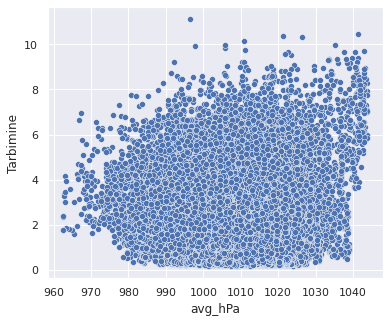

In [ ]:
sns.scatterplot(y=electricity_weather_df['Tarbimine'], x=electricity_weather_df['avg_hPa'])

In [ ]:
# Nii tarbimine kui ka õhurõhk logaritmilises skaalas
sns.scatterplot(y=np.log(electricity_weather_df['Tarbimine']), x=electricity_weather_df['avg_hPa'])

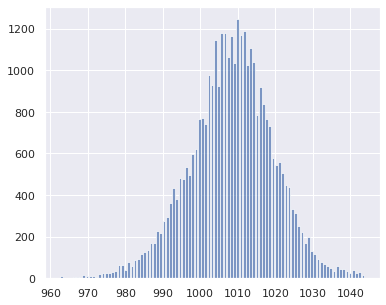

In [ ]:
n, bins, patches = plt.hist(x=electricity_weather_df['avg_hPa'], bins='auto', alpha=0.7, rwidth=0.85)

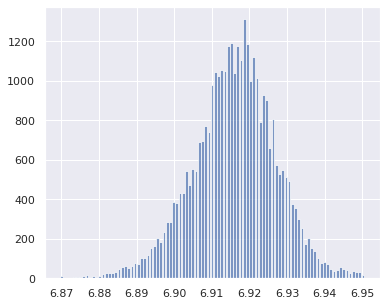

In [ ]:
n, bins, patches = plt.hist(x=np.log(electricity_weather_df['avg_hPa']), bins='auto', alpha=0.7, rwidth=0.85)

## Sademed

In [ ]:
n, bins, patches = plt.hist(x=electricity_weather_df['precipitations_mm'], bins='auto', alpha=0.7, rwidth=0.85)

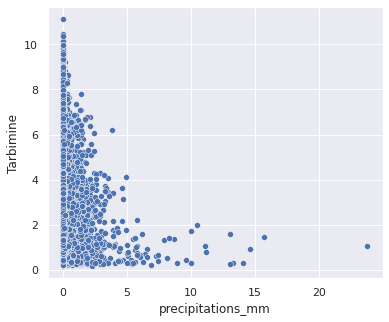

In [ ]:
sns.scatterplot(y=electricity_weather_df['Tarbimine'], x=electricity_weather_df['precipitations_mm'])

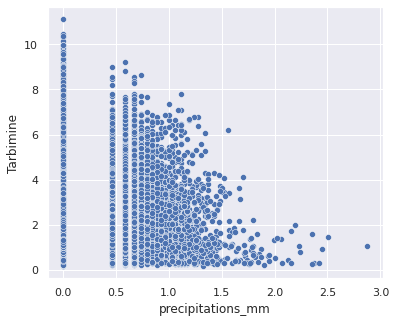

In [ ]:
sns.scatterplot(y=electricity_weather_df['Tarbimine'], x=np.cbrt(electricity_weather_df['precipitations_mm']))

In [ ]:
n, bins, patches = plt.hist(x=np.cbrt(electricity_weather_df['precipitations_mm']), bins='auto', alpha=0.7, rwidth=0.85)

In [ ]:
sns.scatterplot(y=np.log(electricity_weather_df['Tarbimine']), x=np.cbrt(electricity_weather_df['precipitations_mm']))

## Õhuniiskus

In [ ]:
sns.scatterplot(y=electricity_weather_df['Tarbimine'], x=electricity_weather_df['avg_humidity_%'])

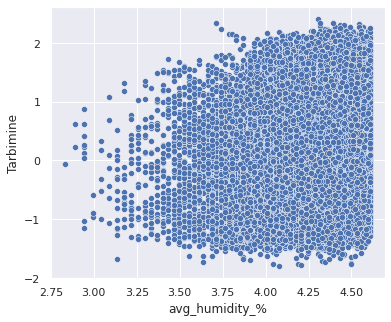

In [ ]:
sns.scatterplot(y=np.log(electricity_weather_df['Tarbimine']), x=np.log(electricity_weather_df['avg_humidity_%']))

Text(0, 0.5, 'Arv')

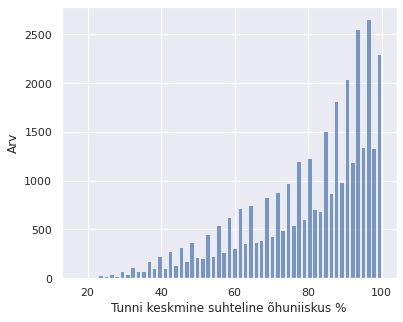

In [ ]:
n, bins, patches = plt.hist(x=electricity_weather_df['avg_humidity_%'], bins='auto', alpha=0.7, rwidth=0.85)
plt.xlabel('Tunni keskmine suhteline õhuniiskus %')
plt.ylabel('Arv')

In [ ]:
n, bins, patches = plt.hist(x=np.log(electricity_weather_df['avg_humidity_%']), bins='auto', alpha=0.7, rwidth=0.85)

## Temperatuur

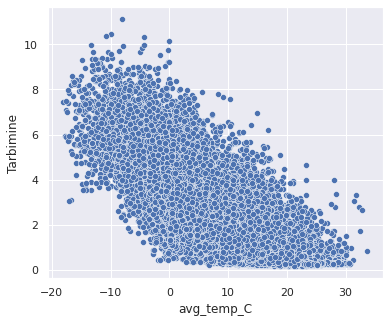

In [ ]:
sns.scatterplot(y=electricity_weather_df['Tarbimine'], x=electricity_weather_df['avg_temp_C'])

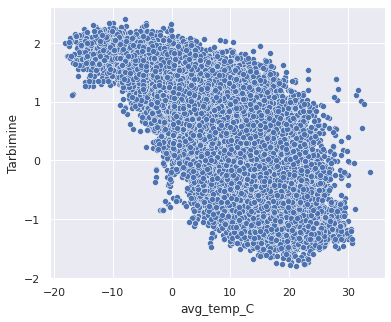

In [ ]:
#Elektritarbimine logaritimilsel skaalal
sns.scatterplot(y=np.log(electricity_weather_df['Tarbimine']), x=electricity_weather_df['avg_temp_C'])

Text(0, 0.5, 'Arv')

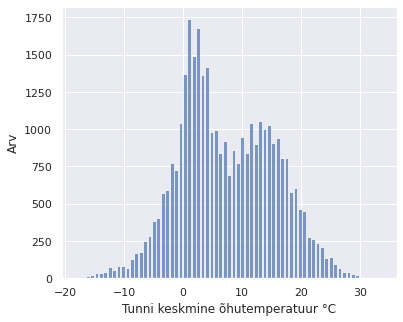

In [ ]:
n, bins, patches = plt.hist(x=electricity_weather_df['avg_temp_C'], bins='auto', alpha=0.7, rwidth=0.85)
plt.xlabel('Tunni keskmine õhutemperatuur °C')
plt.ylabel('Arv')

Text(0, 0.5, 'Jaotustihedus')

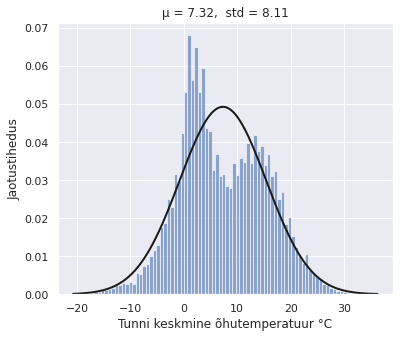

In [ ]:
mu, std = norm.fit(electricity_weather_df['avg_temp_C'])

plt.hist(electricity_weather_df['avg_temp_C'], bins=80, density=True, alpha=0.6)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "µ = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Tunni keskmine õhutemperatuur °C')
plt.ylabel('Jaotustihedus')

## Nähtavus

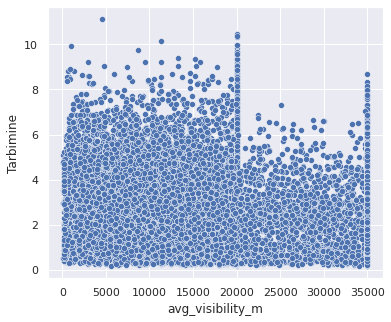

In [ ]:
sns.scatterplot(y=electricity_weather_df['Tarbimine'], x=electricity_weather_df['avg_visibility_m'])

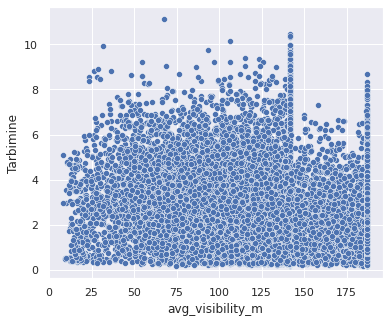

In [ ]:
sns.scatterplot(y=electricity_weather_df['Tarbimine'], x=np.sqrt(electricity_weather_df['avg_visibility_m']))

In [ ]:
sns.scatterplot(y=np.log(electricity_weather_df['Tarbimine']), x=np.log(electricity_weather_df['avg_visibility_m']))

In [ ]:
n, bins, patches = plt.hist(x=electricity_weather_df['avg_visibility_m'], bins='auto', alpha=0.7, rwidth=0.85)

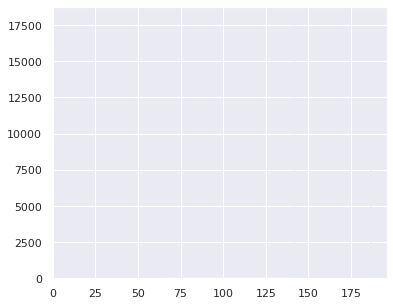

In [ ]:
n, bins, patches = plt.hist(x=np.sqrt(electricity_weather_df['avg_visibility_m']), bins='auto', alpha=0.7, rwidth=0.85)

##Tuulesuund

In [ ]:
sns.scatterplot(y=electricity_weather_df['Tarbimine'], x=electricity_weather_df['avg_wind_direction'])

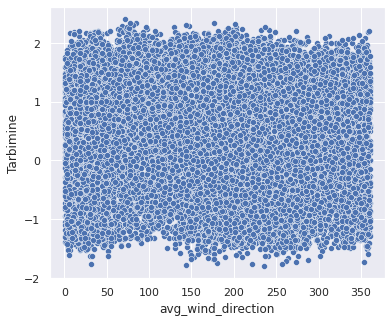

In [ ]:
sns.scatterplot(y=np.log(electricity_weather_df['Tarbimine']), x=electricity_weather_df['avg_wind_direction'])

## Tuulekiirus

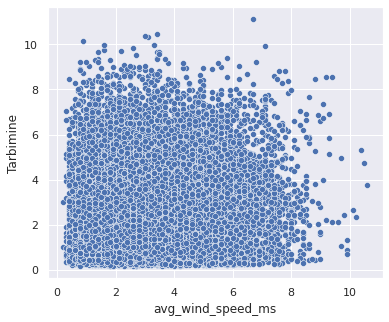

In [ ]:
sns.scatterplot(y=electricity_weather_df['Tarbimine'], x=electricity_weather_df['avg_wind_speed_ms'])

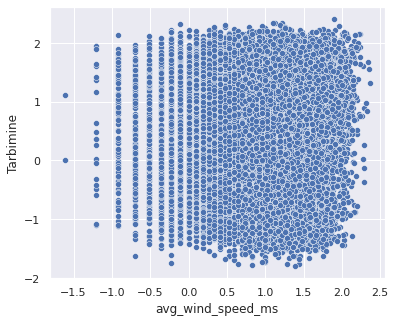

In [ ]:
sns.scatterplot(y=np.log(electricity_weather_df['Tarbimine']), x=np.log(electricity_weather_df['avg_wind_speed_ms']))

In [ ]:
sns.scatterplot(y=electricity_weather_df['Tarbimine'], x=np.sqrt(electricity_weather_df['avg_wind_speed_ms']))

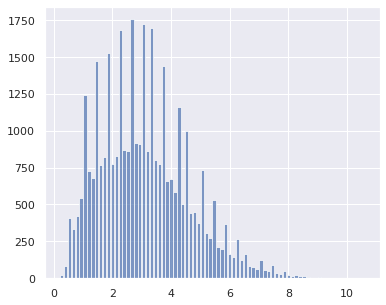

In [ ]:
n, bins, patches = plt.hist(x=electricity_weather_df['avg_wind_speed_ms'], bins='auto', alpha=0.7, rwidth=0.85)

In [ ]:
n, bins, patches = plt.hist(x=np.sqrt(electricity_weather_df['avg_wind_speed_ms']), bins='auto', alpha=0.7, rwidth=0.85)

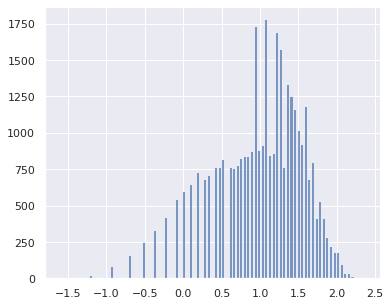

In [ ]:
ln_wind = np.log(electricity_weather_df['avg_wind_speed_ms'])
ln_wind.replace([np.inf, -np.inf], np.nan, inplace=True)
ln_wind.replace([np.inf, -np.inf], np.nan).dropna(how="all", inplace = True)
n, bins, patches = plt.hist(x=ln_wind, bins='auto', alpha=0.7, rwidth=0.85)

## Maksimaalne tuulekiirus

In [ ]:
sns.scatterplot(y=electricity_weather_df['Tarbimine'], x=electricity_weather_df['max_wind_speed_ms'])

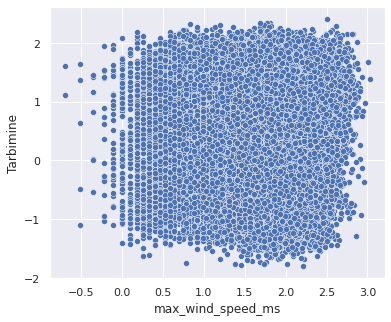

In [ ]:
sns.scatterplot(y=np.log(electricity_weather_df['Tarbimine']), x=np.log(electricity_weather_df['max_wind_speed_ms']))

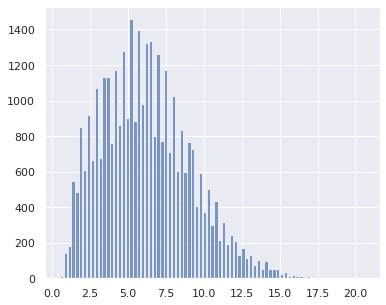

In [ ]:
n, bins, patches = plt.hist(x=electricity_weather_df['max_wind_speed_ms'], bins='auto', alpha=0.7, rwidth=0.85)

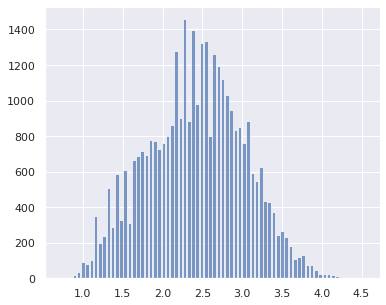

In [ ]:
n, bins, patches = plt.hist(x=np.sqrt(electricity_weather_df['max_wind_speed_ms']), bins='auto', alpha=0.7, rwidth=0.85)

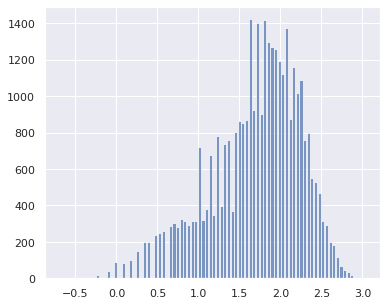

In [ ]:
ln_wind_max = np.log(electricity_weather_df['max_wind_speed_ms'])
ln_wind_max.replace([np.inf, -np.inf], np.nan, inplace=True)
ln_wind_max.replace([np.inf, -np.inf], np.nan).dropna(how="all", inplace = True)
n, bins, patches = plt.hist(x=ln_wind_max, bins='auto', alpha=0.7, rwidth=0.85)

# Korrelatsioonimaatriks trasformeeritud andmetega

In [ ]:
electricity_weather_df_changed_scale = electricity_weather_df_dummies.copy()
electricity_weather_df_changed_scale['Tarbimine'] = np.log(electricity_weather_df_changed_scale['Tarbimine'])
electricity_weather_df_changed_scale['precipitations_mm'] = np.cbrt(electricity_weather_df_changed_scale['precipitations_mm'])
electricity_weather_df_changed_scale['avg_wind_speed_ms'] = np.sqrt(electricity_weather_df_changed_scale['avg_wind_speed_ms'])
electricity_weather_df_changed_scale['max_wind_speed_ms'] = np.sqrt(electricity_weather_df_changed_scale['max_wind_speed_ms'])

In [ ]:
correlationMatrix2 = electricity_weather_df_changed_scale.corr()
fig, ax = plt.subplots(figsize=(25,25))  
sns.heatmap(correlationMatrix2, annot=True)
plt.show()

# Korrelatsiooni heatmap ilma transformeerimata

In [ ]:
import seaborn as sn
correlationMatrix = electricity_weather_df_dummies.corr()
fig, ax = plt.subplots(figsize=(25,25))  
sn.heatmap(correlationMatrix, annot=True)
plt.show()

# Korrelatsiooniimaatriks lihtsustatud andmetega

1. Sademed: Kui sademete määr on üle nulli, saab muutuja väärtuseks 1
2. Õhuniiskus: Kui õhuniiskus on üle 80, siis saab muutuja väärtuseks 1
3. Tuulekiirus: Kui väärtus on üle 6, saab muutuja väärtuseks 1.
4. Maksimaalne tuulekiirus: Kui väärtus on üle 15, saab muutuja väärtuseks 1.


In [ ]:
simplified_data = electricity_weather_df_dummies.copy()

In [ ]:
simplified_data['has_precipitations'] = np.where(simplified_data['precipitations_mm'] > 0, 1, 0)
simplified_data['has_high_humidity_%'] = np.where(simplified_data['avg_humidity_%'] > 80, 1, 0)
simplified_data['has_high_avg_wind_ms'] = np.where(simplified_data['avg_wind_speed_ms'] > 6, 1, 0)
simplified_data['has_high_max_wind_ms'] = np.where(simplified_data['max_wind_speed_ms'] > 15, 1, 0)

In [ ]:
simplified_data.drop(['precipitations_mm', 'avg_humidity_%', 'avg_wind_speed_ms', 'max_wind_speed_ms'], axis=1, inplace=True)

In [ ]:
from scipy import stats
stats.pointbiserialr(np.log(simplified_data['Tarbimine']), simplified_data['has_precipitations'])

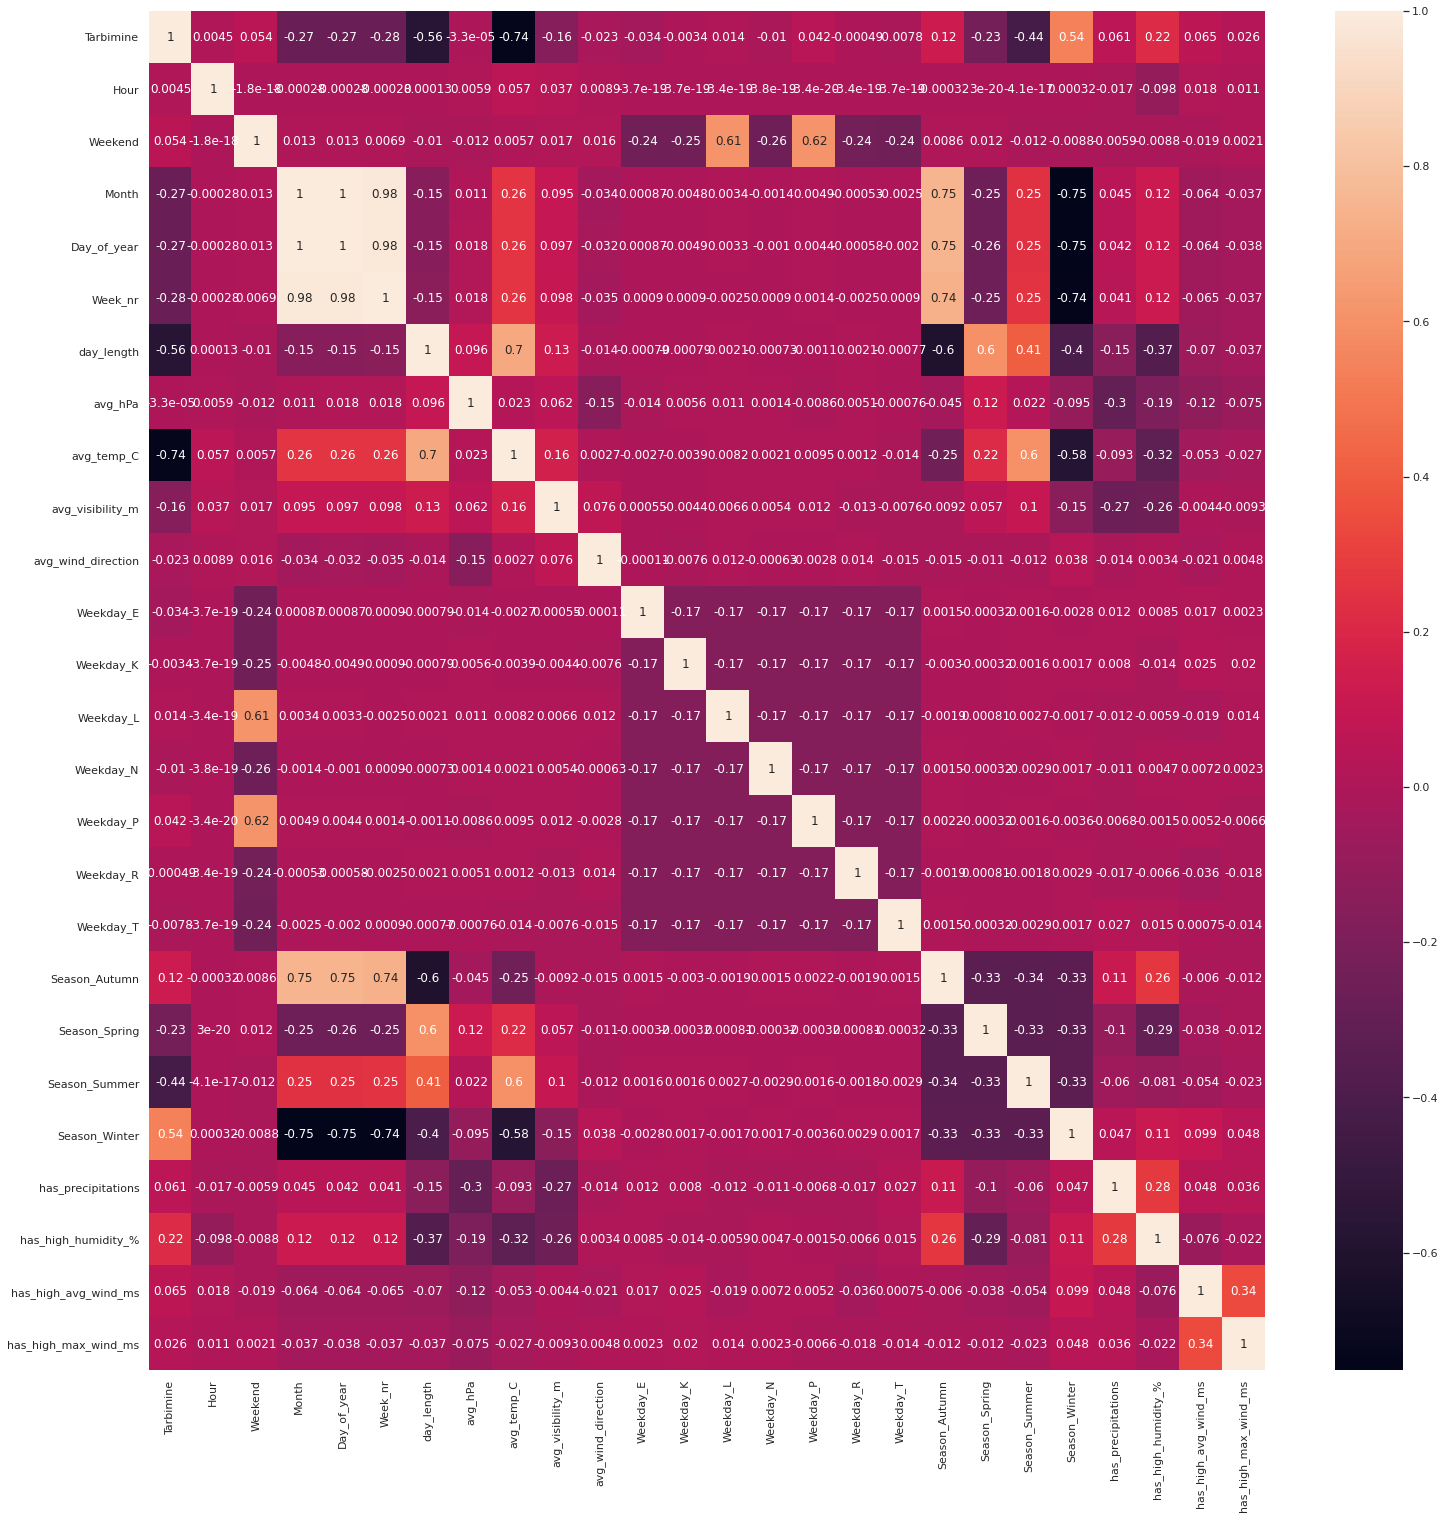

In [ ]:
correlationMatrix3 = simplified_data.corr()
fig, ax = plt.subplots(figsize=(25,25))  
sns.heatmap(correlationMatrix3, annot=True)
plt.show()

In [ ]:
simplified_data_scale = simplified_data.copy()
simplified_data_scale['Tarbimine'] = np.log(simplified_data_scale['Tarbimine'])
correlationMatrix4 = simplified_data_scale.corr()
fig, ax = plt.subplots(figsize=(25,25))  
sns.heatmap(correlationMatrix4, annot=True)
plt.show()

# Andmed valitud ilmastikuparameetritega

In [ ]:
data_with_important_weather_variables = electricity_weather_df_dummies.copy()
data_with_important_weather_variables.head()

Tarbimine        Date  ...  Season_Summer  Season_Winter
Datetime                                    ...                              
2017-01-01 00:00:00      3.190  2017-01-01  ...              0              1
2017-01-01 01:00:00      2.196  2017-01-01  ...              0              1
2017-01-01 02:00:00      2.679  2017-01-01  ...              0              1
2017-01-01 03:00:00      2.269  2017-01-01  ...              0              1
2017-01-01 04:00:00      2.267  2017-01-01  ...              0              1

[5 rows x 28 columns]

In [ ]:
data_with_important_weather_variables.drop(['precipitations_mm', 'avg_wind_speed_ms', 'max_wind_speed_ms', 'avg_hPa', 'avg_visibility_m', 'avg_wind_direction', 'Year'], axis=1, inplace=True)

In [ ]:
data_with_important_weather_variables.head()

Tarbimine        Date  ...  Season_Summer  Season_Winter
Datetime                                    ...                              
2017-01-01 00:00:00      3.190  2017-01-01  ...              0              1
2017-01-01 01:00:00      2.196  2017-01-01  ...              0              1
2017-01-01 02:00:00      2.679  2017-01-01  ...              0              1
2017-01-01 03:00:00      2.269  2017-01-01  ...              0              1
2017-01-01 04:00:00      2.267  2017-01-01  ...              0              1

[5 rows x 21 columns]

In [ ]:
x_axis_labels = ['Tarbimine','Tund','Nädalavahetus','Kuu','Päeva järjenumber','Nädala number','Päevavalgus','Suhteline õhuniiskus', 'Temperatuur',
                 'Esmaspäev', 'Kolmapäev', 'Laupäev', 'Neljapäev', 'Pühapäev', 'Reede', 'Teisipäev', 'Sügis', 'Kevad', 'Suvi', 'Talv']
y_axis_labels = ['Tarbimine','Tund','Nädalavahetus','Kuu','Päeva järjenumber','Nädala number','Päevavalgus','Suhteline õhuniiskus','Temperatuur',
                 'Esmaspäev', 'Kolmapäev', 'Laupäev', 'Neljapäev', 'Pühapäev', 'Reede', 'Teisipäev', 'Sügis', 'Kevad', 'Suvi', 'Talv'] 
correlationMatrix5 = data_with_important_weather_variables.corr()
fig, ax = plt.subplots(figsize=(25,25))  
sns.heatmap(correlationMatrix5, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.show()

# Temperatuur vs tarbimine

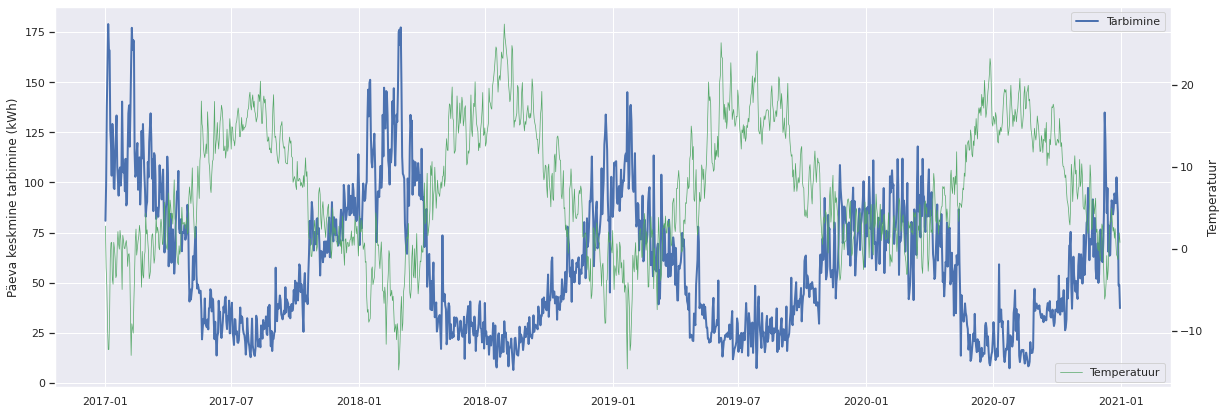

In [ ]:
temperature_daily= data_with_important_weather_variables['avg_temp_C'].resample('D').mean()
fig, ax = plt.subplots(figsize=(20,7))
ax_right =ax.twinx()

ax.plot(consumption_daily, linestyle='-', linewidth=2, label='Tarbimine')
ax_right.plot(temperature_daily, linewidth=0.7, linestyle='-', label='Temperatuur', color = 'g')
ax.set_ylabel('Päeva keskmine tarbimine (kWh)')
ax_right.set_ylabel('Temperatuur')
ax.legend()
ax_right.legend(loc = 'lower right')
ax_right.grid(False)

# Parameetrite leidmine

## Tavaandmed

In [ ]:
electricity_weather_df_dummies = pd.get_dummies(electricity_weather_df, columns=['Weekday', 'Month'],  dtype=int)

In [ ]:
normalized=electricity_weather_df_dummies.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

In [ ]:
X = normalized.drop(['Tarbimine'], axis = 1)
y = normalized.loc[:, 'Tarbimine']

In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.352722
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Tarbimine   No. Observations:                35064
Model:                          Logit   Df Residuals:                    35033
Method:                           MLE   Df Model:                           30
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                  -1.602
Time:                        12:56:58   Log-Likelihood:                -12368.
converged:                       True   LL-Null:                       -4753.5
Covariance Type:            nonrobust   LLR p-value:                     1.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Hour                   0.1228      0.046      2.694      0.007       0.033       0.212
Weeke

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, f_classif
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=20)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
dfpvalues = pd.DataFrame(fit.pvalues_)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] 
print(featureScores.nlargest(10,'Score'))  

            Specs     Score
8      avg_temp_C  8.627872
4      day_length  4.335293
23  Season_Winter  3.696732
25        Month_2  2.670354
24        Month_1  2.553831
22  Season_Summer  2.205319
26        Month_3  1.830397
3         Week_nr  1.821694
2     Day_of_year  1.809179
35       Month_12  1.708391


In [ ]:
kbest = featureScores.set_index('Specs')

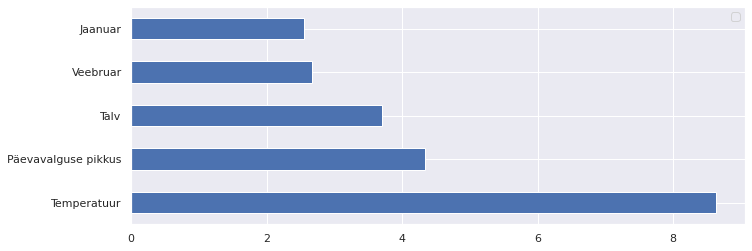

In [ ]:
kbest.nlargest(5, 'Score').plot(kind='barh')
plt.yticks([0,1, 2, 3, 4], ['Temperatuur', 'Päevavalguse pikkus', 'Talv', 'Veebruar',  'Jaanuar'])
plt.ylabel('')
plt.legend("")
plt.show()

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
sns.set(rc={'figure.figsize':(11, 4)})
model = ExtraTreesRegressor()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

[0.07896762 0.01015656 0.04115213 0.03805246 0.03969448 0.04329051
 0.00839818 0.03082893 0.28841186 0.02317097 0.03109162 0.02739133
 0.0262388  0.00661531 0.00640466 0.00492366 0.00628795 0.00622935
 0.00732891 0.00631423 0.0280163  0.00086781 0.00135171 0.20424037
 0.0015559  0.00213323 0.00280159 0.01138379 0.00202218 0.00085993
 0.00091899 0.00077165 0.00177215 0.00433371 0.00185552 0.00416566]


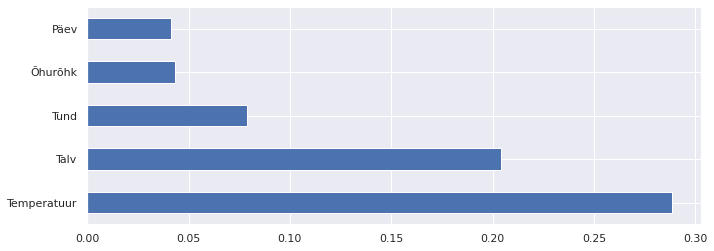

In [ ]:
feat_importances.nlargest(5).plot(kind='barh')
plt.yticks([0,1, 2, 3, 4], ['Temperatuur', 'Talv', 'Tund',  'Õhurõhk', 'Päev'])
plt.show()

## Lihtsustatud andmed

In [ ]:
normalized_simple=simplified_data.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

In [ ]:
X_s = normalized_simple.drop(['Tarbimine'], axis = 1)
y_s = normalized_simple.loc[:, 'Tarbimine']

In [ ]:
bestfeatures = SelectKBest(score_func=f_classif, k=20)
fit = bestfeatures.fit(X_s,y_s)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_s.columns)
featureScores_s = pd.concat([dfcolumns,dfscores],axis=1)
featureScores_s.columns = ['Specs','Score']  
print(featureScores_s.nlargest(10,'Score'))  

            Specs     Score
6      avg_temp_C  8.627872
4      day_length  4.335293
19  Season_Winter  3.696732
21        Month_2  2.670354
20        Month_1  2.553831
18  Season_Summer  2.205319
22        Month_3  1.830397
3         Week_nr  1.821694
2     Day_of_year  1.809179
31       Month_12  1.708391


In [ ]:
model_s = ExtraTreesRegressor()
model_s.fit(X_s,y_s)
print(model.feature_importances_)
feat_importances_S = pd.Series(model_s.feature_importances_, index=X_s.columns)

[0.09435083 0.01069234 0.05199228 0.03356266 0.04855644 0.05553774
 0.2696064  0.02816937 0.04249688 0.00717672 0.00705433 0.00527166
 0.00678915 0.00645102 0.00798995 0.00692727 0.03026261 0.00088991
 0.00208987 0.22151657 0.00162256 0.00223891 0.00292025 0.01308199
 0.00209642 0.00087335 0.00095569 0.00084234 0.00167198 0.00485854
 0.00186757 0.00492743 0.00770884 0.01171084 0.00463233 0.00060696]


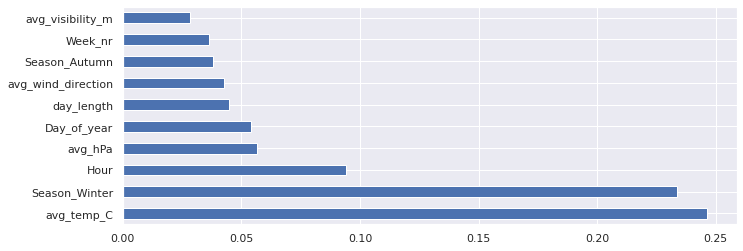

In [ ]:
feat_importances_S.nlargest(10).plot(kind='barh')
plt.show()

# Päikesepaneelide tootlikus kuus ja meie tarbimine

In [ ]:
months = ['Jaanuar', 'Veebruar', 'Märts', 'Aprill','Mai', 'Juuni', 'Juuli', 'August', 'September', 'Oktoober', 'November', 'Detsember'] 
grouped_month = index_data.groupby('Month')['Tarbimine'].sum()

In [ ]:
grouped_month

Month
1     12537.990
2     11640.659
3     10912.232
4      7346.413
5      4693.666
6      3059.858
7      2926.426
8      2756.302
9      4139.223
10     6147.476
11     8109.097
12    10374.704
Name: Tarbimine, dtype: float64

In [ ]:
df_paneelid_kuus = pd.DataFrame({"Kuu":['Jan', 'Veebr', 'Märts', 'Apr', 'Mai', 'Juuni', 'Juuli', 'Aug', 'Sept', 'Okt', 'Nov', 'Dets'] ,
                    "Elektritarbimine":[12537.990/4, 11640.659/4, 10912.232/4, 7346.413/4, 4693.666/4, 3059.858/4, 2926.426/4, 2756.302/4, 4139.223/4, 6147.476/4, 8109.097/4, 10374.704/4 ], #jagan neljaga et saada aasta keskmine
                    "Tootlikkus":[273.88, 729.74, 1832.97, 2629.17, 3296.38, 3180.07, 3183.55, 2619.1, 1729.16, 978.92, 282.84, 171.41]})
#https://re.jrc.ec.europa.eu/pvg_tools/en/tools.html

In [ ]:
df_paneelid_kuus.head()

Kuu  Elektritarbimine  Tootlikkus
0    Jan        3134.49750      273.88
1  Veebr        2910.16475      729.74
2  Märts        2728.05800     1832.97
3    Apr        1836.60325     2629.17
4    Mai        1173.41650     3296.38

In [ ]:
# Selle arvutusega saab teada, mis oleks tasuvusperiood, kui päikesepaneelid toodaks 70% nende võimalikust tootmisest (varjude tõttu)
#df_paneelid_kuus['Tootlikkus'] = df_paneelid_kuus['Tootlikkus'] * 0.7

In [ ]:
df_paneelid_kuus['Päikeseenergia ülejääk'] = df_paneelid_kuus['Tootlikkus'] - df_paneelid_kuus['Elektritarbimine'] 

In [ ]:
df_paneelid_kuus

Kuu  Elektritarbimine  Tootlikkus  Päikeseenergia ülejääk
0     Jan        3134.49750      273.88             -2860.61750
1   Veebr        2910.16475      729.74             -2180.42475
2   Märts        2728.05800     1832.97              -895.08800
3     Apr        1836.60325     2629.17               792.56675
4     Mai        1173.41650     3296.38              2122.96350
5   Juuni         764.96450     3180.07              2415.10550
6   Juuli         731.60650     3183.55              2451.94350
7     Aug         689.07550     2619.10              1930.02450
8    Sept        1034.80575     1729.16               694.35425
9     Okt        1536.86900      978.92              -557.94900
10    Nov        2027.27425      282.84             -1744.43425
11   Dets        2593.67600      171.41             -2422.26600

No handles with labels found to put in legend.


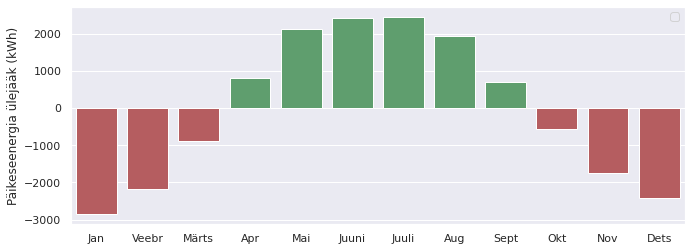

In [ ]:
fig, ax1 = plt.subplots()
clrs = ['g' if (x > 0) else 'r' for x in df_paneelid_kuus['Päikeseenergia ülejääk']]
#sb.barplot(x=idx, y=values, palette=clrs) # color=clrs)

sns.barplot(data = df_paneelid_kuus, x=df_paneelid_kuus['Kuu'], y='Päikeseenergia ülejääk', ax=ax1, palette=clrs)
ax1.set_ylabel('Päikeseenergia ülejääk (kWh)')
ax1.set_xlabel('')
ax1.legend()

In [ ]:
fig, ax1 = plt.subplots()
sns.barplot(data = df_paneelid_kuus, x=df_paneelid_kuus['Kuu'], y='Elektritarbimine', ax=ax1, color='b')
ax1.set_ylabel('Kuu keskmine elektritarbimine (kWh)')
ax1.set_xlabel('')
sns.lineplot(data = df_paneelid_kuus['Tootlikkus'], marker='o', sort = False, ax=ax1, color='g', label = 'Päikesepaneelide tootlikkus')
ax1.legend()

# Nord Pool hinnad

In [ ]:
elektrihinnad_url = 'http://lennuki.myqnapcloud.com:8080/share.cgi?ssid=0F1KvSk&fid=0F1KvSk&filename=elektrihinnad%202017-2020.xlsx&openfolder=forcedownload&ep='
hinnad_df = pd.read_excel(elektrihinnad_url,  header=0)

hinnad_df["Datetime"] = hinnad_df['Date'].astype(str) + ' ' + hinnad_df['Hours'].str.strip() + ':00'
hinnad_df['Datetime']=pd.to_datetime(hinnad_df['Datetime'], format='%Y-%m-%d %H:%M')
hinnad_df.drop(['Date', 'Hours','EUR/MWH'], axis =1, inplace=True)

#Calculate replacement for NA values
index_hinnad= hinnad_df.set_index('Datetime')
index_hinnad.at['2017-03-26 02:00:00', 'EUR/KWH'] = (index_hinnad.loc['2017-03-26 01:00:00', 'EUR/KWH'] + index_hinnad.loc['2017-03-26 03:00:00', 'EUR/KWH'])/2 
index_hinnad.at['2018-03-25 02:00:00', 'EUR/KWH'] = (index_hinnad.loc['2018-03-25 01:00:00', 'EUR/KWH'] + index_hinnad.loc['2018-03-25 03:00:00', 'EUR/KWH'])/2 
index_hinnad.at['2019-03-31 02:00:00', 'EUR/KWH'] = (index_hinnad.loc['2019-03-31 01:00:00', 'EUR/KWH'] + index_hinnad.loc['2019-03-31 03:00:00', 'EUR/KWH'])/2 
index_hinnad.at['2020-03-29 02:00:00', 'EUR/KWH'] = (index_hinnad.loc['2020-03-29 01:00:00', 'EUR/KWH'] + index_hinnad.loc['2020-03-29 03:00:00', 'EUR/KWH'])/2 

#Olin eur/kwh valesti arvutanud excelis
index_hinnad['senti/kWh'] = index_hinnad['EUR/KWH'] * 10
index_hinnad.drop('EUR/KWH', axis=1, inplace=True)

from pandas.tseries.offsets import DateOffset
index_hinnad['ts'] = index_hinnad.index + pd.offsets.Hour(1)
index_hinnad= index_hinnad.set_index('ts')

#Merge prices
index_data = pd.merge(index_data, index_hinnad, left_index=True, right_index=True )

In [ ]:
df_filtered_argi = index_data.query('Weekend == 0')
df_filtered_nv = index_data.query('Weekend == 1')

grouped_hour_with_prices = index_data.groupby('Hour').agg({'Tarbimine':'mean', 'senti/kWh':'mean'})
grouped_hour_with_prices_argi = df_filtered_argi.groupby('Hour').agg({'Tarbimine':'mean', 'senti/kWh':'mean'})
grouped_hour_with_prices_nv = df_filtered_nv.groupby('Hour').agg({'Tarbimine':'mean', 'senti/kWh':'mean'})
grouped_hour_with_prices_2017 = index_data.loc['20170101':'20171231'].groupby('Hour').agg({'Tarbimine':'mean', 'senti/kWh':'mean'})

Text(0, 0.5, 'senti/kWh')

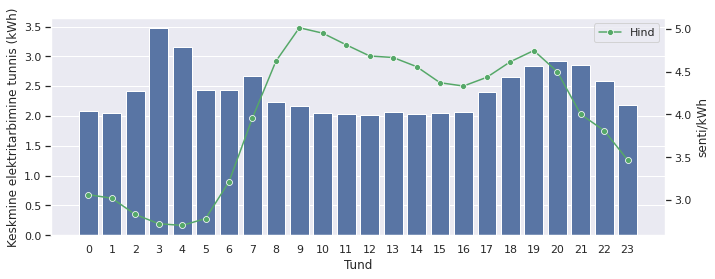

In [ ]:
fig, ax1 = plt.subplots()
sns.barplot(data = grouped_hour_with_prices, x=grouped_hour_with_prices.index, y='Tarbimine', ax=ax1, color='b')
ax1.set_ylabel('Keskmine elektritarbimine tunnis (kWh)')
ax1.set_xlabel('Tund')


ax2 = ax1.twinx()
sns.lineplot(data = grouped_hour_with_prices['senti/kWh'], marker='o', sort = False, ax=ax2, color='g', legend = 'auto')
ax2.grid(False)
ax2.legend(['Hind'],loc = 'upper right')
ax2.set_ylabel('senti/kWh')


In [ ]:
#vaatame nädalavahetust eraldi
fig, ax1 = plt.subplots()
sns.barplot(data = grouped_hour_with_prices_nv, x=grouped_hour_with_prices_nv.index, y='Tarbimine', ax=ax1, color='b')
ax1.set_ylabel('Keskmine tarbimine tunnis nädalavahetusel (kWh)')
ax1.set_xlabel('Tund')


ax2 = ax1.twinx()
sns.lineplot(data = grouped_hour_with_prices_nv['senti/kWh'], marker='o', sort = False, ax=ax2, color='g', legend = 'auto')
ax2.grid(False)
ax2.legend(['Hind'],loc = 'upper right')
ax2.set_ylabel('senti/kWh')

Text(0, 0.5, 'senti/kWh')

In [ ]:
#vaatame argipäeva eraldi
fig, ax1 = plt.subplots()
sns.barplot(data = grouped_hour_with_prices_argi, x=grouped_hour_with_prices_argi.index, y='Tarbimine', ax=ax1, color='b')
ax1.set_ylabel('Keskmine tarbimine tunnis argipäeval (kWh)')
ax1.set_xlabel('Tund')


ax2 = ax1.twinx()
sns.lineplot(data = grouped_hour_with_prices_argi['senti/kWh'], marker='o', sort = False, ax=ax2, color='g', legend = 'auto')
ax2.legend(['Hind'],loc = 'upper right')
ax2.grid(False)
ax2.set_ylabel('senti/kWh')

Text(0, 0.5, 'senti/kWh')

In [ ]:
grouped_price_w = index_data.groupby('Week_nr').agg({'Tarbimine':'sum', 'senti/kWh':'mean'})

Text(0, 0.5, 'Aaastate keskmine hind tunnis (senti/kWh)')

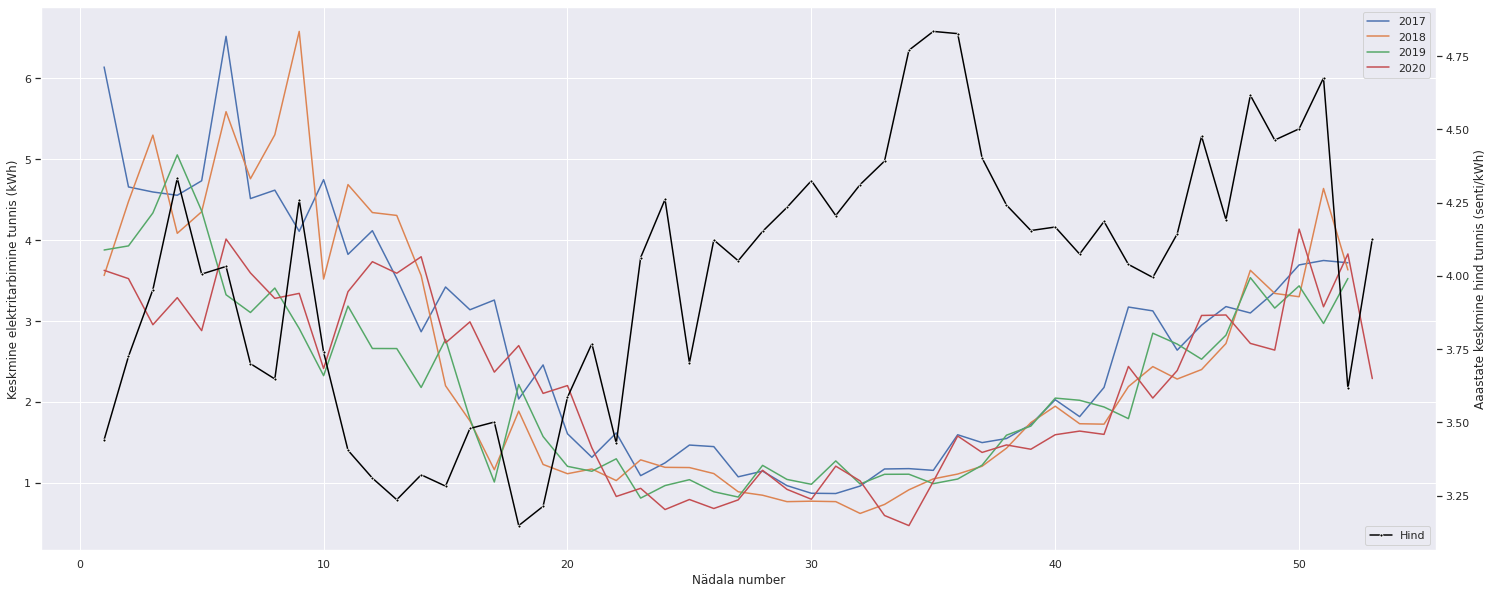

In [ ]:
#Average hourly consuption by day of year
weekly_data_pivot = pd.pivot_table(index_data, index =['Week_nr'], columns=['Year'], values=['Tarbimine'])
ax1 = weekly_data_pivot.plot(figsize=(25,10))
plt.ylabel('Keskmine elektritarbimine tunnis (kWh)')
plt.xlabel('Nädala number')
plt.legend(['2017', '2018', '2019', '2020'])


ax2 = ax1.twinx()
#plt.plot(data = grouped_price['EUR/KWH'], linewidth=5, ax=ax2, color='black')
sns.lineplot(data = grouped_price_w['senti/kWh'], marker='.', sort = False, ax=ax2, color='black', legend = 'auto')
ax2.legend(['Hind'],loc = 'lower right')
ax2.grid(False)
ax2.set_ylabel('Aaastate keskmine hind tunnis (senti/kWh)')


# Päikesepaneelidest sääst

In [ ]:
prices = index_data.copy()

In [ ]:
prices['pohitasu_€'] = (prices['Tarbimine'] * prices['senti/kWh'])/100
prices.head()

Tarbimine        Date  ... senti/kWh  pohitasu_€
2017-01-01 01:00:00      2.196  2017-01-01  ...     2.403    0.052770
2017-01-01 02:00:00      2.679  2017-01-01  ...     2.403    0.064376
2017-01-01 03:00:00      2.269  2017-01-01  ...     2.402    0.054501
2017-01-01 04:00:00      2.267  2017-01-01  ...     2.319    0.052572
2017-01-01 05:00:00      2.453  2017-01-01  ...     2.410    0.059117

[5 rows x 13 columns]

Võrguteenustasud (arve pealt võetud):
- elektri edastamine päev 0,0274 €/kWh
- elektri edastamine öö 0,0158 €/kWh
- kuutasu 14,46 € kuus (seda arvutustesse ka ei lisa, kuna see ei sõltu tarbimisest)
- taastuvenergia tasu 0,0113 €/kWh
- elektriaktsiis 0,001 €/kWh

-------------------------------------------------
- Päevahind (elektri edastamine: päev) kehtib esmaspäevast reedeni: suvel kell 8.00-24.00 ning talvel kell 7.00-23.00.
- Ööhind (elektri edastamine: öö) kehtib esmaspäevast reedeni: suvel kell 24.00-8.00 ja talvel kell 23.00-7.00 ning kõigil laupäevadel ja pühapäevadel.
- Argipäevadele langevatel riiklikel pühadel kehtivad samad hinnad, mis tavalistel argipäevadel
- Kõigile tasudele ja aktsiisile lisandub käibemaks. (Mina seda oma töös ei lisa)
- Suveajale minnakse Euroopas märtsi viimasel pühapäeval kell 01:00 UTC (Eestis 3:00) ja tagasi vööndiajale minnakse oktoobri viimasel pühapäeval kell 01:00 UTC (Eestis 4:00)
  - lihtsustuse mõtettes jaotan lihtsalt suvekuudeks (kuud 4, 5, 6, 7, 8, 9, 10) ja talvekuudeks (11, 12, 1, 2, 3)

Allikas: https://www.elektrilevi.ee/-/doc/6305157/kliendile/elektrilevi_hinnatariifid_2019.pdf

In [ ]:
prices['aktsiis_€'] = prices['Tarbimine'] * 0.001


In [ ]:
prices['taastuvenergia_€'] = prices['Tarbimine'] * 0.0113
prices.head()

Tarbimine        Date  ... aktsiis_€  taastuvenergia_€
2017-01-01 01:00:00      2.196  2017-01-01  ...  0.002196          0.024815
2017-01-01 02:00:00      2.679  2017-01-01  ...  0.002679          0.030273
2017-01-01 03:00:00      2.269  2017-01-01  ...  0.002269          0.025640
2017-01-01 04:00:00      2.267  2017-01-01  ...  0.002267          0.025617
2017-01-01 05:00:00      2.453  2017-01-01  ...  0.002453          0.027719

[5 rows x 15 columns]

In [ ]:
price_conditions = [
    ((prices['Month'] >=4) & (prices['Month'] <=10)) & (prices['Hour'] >= 8) & (prices['Weekday'] != 'L') & (prices['Weekday'] != 'P'), #suve päevahind

    ((prices['Month'] >=4) & (prices['Month'] <=10)) & (prices['Hour'] < 8) & (prices['Weekday'] != 'L') & (prices['Weekday'] != 'P'), #suve ööhind

    ((prices['Month'] <=3) | (prices['Month'] >=11)) & (prices['Hour'] >= 7) & (prices['Hour'] != 23) & (prices['Weekday'] != 'L') & (prices['Weekday'] != 'P'), #talve päevahind

    ((prices['Month'] <=3) | (prices['Month'] >=11)) & ((prices['Hour'] < 7 ) | (prices['Hour']  == 23 )) & (prices['Weekday'] != 'L') & (prices['Weekday'] != 'P'), #talve ööhind

    (prices['Weekday'] == 'L') | (prices['Weekday'] == 'P') #nädalavahetus
]

price_values = [0.0274, 0.0158, 0.0274, 0.0158, 0.0158]
#price_values = ["suvi_päev", "suvi_öö", "talv_päev", "talv_öö", "nädalavahetus"]

prices['vorgutasu_määr_€'] = np.select(price_conditions, price_values)

In [ ]:
prices['vorgutasu_€'] = prices['vorgutasu_määr_€'] * prices['Tarbimine']

In [ ]:
prices.head()

Tarbimine        Date  ... vorgutasu_määr_€  vorgutasu_€
2017-01-01 01:00:00      2.196  2017-01-01  ...           0.0158     0.034697
2017-01-01 02:00:00      2.679  2017-01-01  ...           0.0158     0.042328
2017-01-01 03:00:00      2.269  2017-01-01  ...           0.0158     0.035850
2017-01-01 04:00:00      2.267  2017-01-01  ...           0.0158     0.035819
2017-01-01 05:00:00      2.453  2017-01-01  ...           0.0158     0.038757

[5 rows x 17 columns]

In [ ]:
prices['lisatasud_€'] = prices['aktsiis_€'] + prices['taastuvenergia_€'] + prices['vorgutasu_€']

In [ ]:
prices['total_price_€'] = prices['lisatasud_€'] + prices['pohitasu_€']

In [ ]:
prices.head()

Tarbimine        Date  ... lisatasud_€  total_price_€
2017-01-01 01:00:00      2.196  2017-01-01  ...    0.061708       0.114477
2017-01-01 02:00:00      2.679  2017-01-01  ...    0.075280       0.139656
2017-01-01 03:00:00      2.269  2017-01-01  ...    0.063759       0.118260
2017-01-01 04:00:00      2.267  2017-01-01  ...    0.063703       0.116274
2017-01-01 05:00:00      2.453  2017-01-01  ...    0.068929       0.128047

[5 rows x 19 columns]

In [ ]:
grouped_month_prices = prices.groupby('Month').agg({'total_price_€':'sum', 'senti/kWh':'mean'})

#take the average
grouped_month_prices['avg_elektrikulu'] = (grouped_month_prices['total_price_€']/4)
grouped_month_prices

total_price_€  senti/kWh  avg_elektrikulu
Month                                           
1         921.888183   3.923721       230.472046
2         839.184751   3.837813       209.796188
3         750.225310   3.502556       187.556327
4         477.549341   3.423837       119.387335
5         299.210367   3.416682        74.802592
6         209.835286   3.992385        52.458821
7         217.976058   4.183171        54.494014
8         211.545966   4.542751        52.886491
9         309.539181   4.415180        77.384795
10        447.992477   4.122760       111.998119
11        602.219478   4.324985       150.554870
12        771.288980   4.241322       192.822245

In [ ]:
grouped_month_prices.sum(axis=0)

total_price_€      6058.300657
senti/kWh            47.927162
avg_elektrikulu    1514.575164
dtype: float64

In [ ]:
grouped_month_prices= grouped_month_prices.reset_index()

In [ ]:
grouped_month_prices

Month  total_price_€  senti/kWh  avg_elektrikulu
0       1     921.888183   3.923721       230.472046
1       2     839.184751   3.837813       209.796188
2       3     750.225310   3.502556       187.556327
3       4     477.469459   3.423837       119.367365
4       5     299.210367   3.416682        74.802592
5       6     209.835286   3.992385        52.458821
6       7     217.976058   4.183171        54.494014
7       8     211.545966   4.542751        52.886491
8       9     309.539181   4.415180        77.384795
9      10     447.992477   4.122760       111.998119
10     11     602.144639   4.324985       150.536160
11     12     771.288980   4.241322       192.822245

In [ ]:
tasuvus = pd.concat([grouped_month_prices, df_paneelid_kuus], axis=1)

In [ ]:
tasuvus.drop(['total_price_€', 'Month'], axis=1, inplace=True)

In [ ]:
tasuvus['sääst']  = np.where(
    tasuvus['Päikeseenergia ülejääk'] < 0, 
    (tasuvus['Tootlikkus'] / tasuvus['Elektritarbimine']) * tasuvus['avg_elektrikulu'], 
    tasuvus['avg_elektrikulu'])

In [ ]:
#https://www.aripaev.ee/uudised/2015/04/22/elektrijaama-saab-pusti-lihtsalt-paberimajandusega-pisut-pusimist
#marginaal on 0,18–0,25 senti ehk võtsin keskmise, mis on 0.215

tasuvus['müük']  = np.where(
    tasuvus['Päikeseenergia ülejääk'] > 0, 
    tasuvus['Päikeseenergia ülejääk'] * (tasuvus['senti/kWh']/100) -(0.215/100 * tasuvus['Päikeseenergia ülejääk']), 
    0)

In [ ]:
tasuvus

senti/kWh  avg_elektrikulu  ...       sääst       müük
0    3.923721       230.472046  ...   20.137736   0.000000
1    3.837813       209.796188  ...   52.607561   0.000000
2    3.502556       187.556327  ...  126.018260   0.000000
3    3.423837       119.387335  ...  119.387335  25.432176
4    3.416682        74.802592  ...   74.802592  67.970543
5    3.992385        52.458821  ...   52.458821  91.227826
6    4.183171        54.494014  ...   54.494014  97.297304
7    4.542751        52.886491  ...   52.886491  83.526655
8    4.415180        77.384795  ...   77.384795  29.164125
9    4.122760       111.998119  ...   71.338025   0.000000
10   4.324985       150.554870  ...   21.005022   0.000000
11   4.241322       192.822245  ...   12.743173   0.000000

[12 rows x 8 columns]

In [ ]:
tasuvus.sum(axis=0)

senti/kWh                                                        47.9272
avg_elektrikulu                                                  1514.61
Kuu                       JanVeebrMärtsAprMaiJuuniJuuliAugSeptOktNovDets
Elektritarbimine                                                   21161
Tootlikkus                                                       20907.2
Päikeseenergia ülejääk                                          -253.821
sääst                                                            735.264
müük                                                             394.619
dtype: object